<a href="https://colab.research.google.com/github/kalissiopea/smartcitywastemanage/blob/main/CombBilceStorici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import pandas as pd

# Caricamento file CSV
ottimizzazione = pd.read_csv('strategieOttimizzazioneStorico.csv', sep=';')  # Usa il separatore corretto (ad es. `;`)
sviluppo = pd.read_csv('strategieSviluppoStorico.csv', sep=';', low_memory=False)
bilce = pd.read_excel('storico_tracciati_BILCE.xlsx')


In [21]:
import pandas as pd

# Carica il file Excel
file_path = 'storico_tracciati_BILCE.xlsx'  # Percorso del file
sheet_name = 0  # Seleziona il primo foglio

# Legge tutto il file Excel senza intestazione
df = pd.read_excel(file_path, sheet_name=sheet_name, header=None)

# Usa la riga 2 come intestazione (indice 1)
header_row = 1
df.columns = df.iloc[header_row]

# Elimina tutte le righe precedenti all'intestazione
df = df.iloc[header_row + 1:].reset_index(drop=True)

# Rimuovi la riga duplicata dell'intestazione
df = df[df[df.columns[0]] != df.columns[0]]

# Rimuovi colonne duplicate o vuote
df = df.loc[:, ~df.columns.duplicated()]  # Colonne duplicate
df = df.dropna(axis=1, how='all')  # Colonne completamente vuote

# Rimuovi righe completamente vuote
df = df.dropna(axis=0, how='all')

# Rimuove colonne con oltre il 50% di valori nulli
threshold = 0.5 * len(df)
df = df.dropna(axis=1, thresh=threshold)
# Identifica la prima colonna
prima_colonna = df.columns[0]  # Nome della prima colonna
# Filtra le righe in cui la prima colonna NON contiene la parola "CSE"
df = df[~df[prima_colonna].str.contains('CSE', na=False)]

# Riepilogo del DataFrame
print(df.info())
print(df.head())


<class 'pandas.core.frame.DataFrame'>
Index: 91 entries, 1 to 107
Columns: 207 entries, NDG to Sensibilità
dtypes: object(207)
memory usage: 147.9+ KB
None
1     NDG                                    Ragione sociale Codice fiscale  \
1    4975  Immobiliare Lovicario S.A.S. Di Michele Lovica...    01045960729   
2    4983                                        Pandiva Srl    00261740724   
3    4983                                        Pandiva Srl    00261740724   
4  175442                                    Alba Chiara Srl    02923020727   
5  175442                                    Alba Chiara Srl    02923020727   

1 Filiale    Ateco Ateco corrente    CAP           Comune  \
1   21360  '682001        '682001  70023  Gioia Del Colle   
2   21360    '4711          '4711  70023  Gioia Del Colle   
3   21360    '4711          '4711  70023  Gioia Del Colle   
4   21235  '682001        '682001  76125            Trani   
5   21235  '682001        '682001  76125            Trani   

1 

In [22]:
print(df.columns)  # Stampa i nomi delle colonne per individuare quello corretto


Index(['NDG', 'Ragione sociale', 'Codice fiscale', 'Filiale', 'Ateco',
       'Ateco corrente', 'CAP', 'Comune', 'Indirizzo', 'Provincia',
       ...
       'ROD',
       'ROT rotazione capitale investito o fatturato per euro investito',
       'rotazione delle rimanenze di magazzino', 'valore aggiunto',
       'vendite per dipendente', 'vita residua immobilizz',
       'Gearing ratio (PFN/PN)', 'PFL', 'Punteggio Azienda', 'Sensibilità'],
      dtype='object', name=1, length=207)


In [23]:
# Nome corretto della colonna che contiene NDG
ndg_col = 'NDG'  # Modifica in base al nome corretto

# Confronto con i file storico_ottimizzazione e storico_sviluppo
df['presente_in_ottimizzazione'] = df[ndg_col].isin(ottimizzazione['ndg'])
df['presente_in_sviluppo'] = df[ndg_col].isin(sviluppo['ndg'])
# Aggiungi una colonna che indica se è presente in almeno uno dei due storici
df['presente_in_almeno_uno'] = df['presente_in_ottimizzazione'] | df['presente_in_sviluppo']

# Aggiungi una colonna che indica se è presente in entrambi
df['presente_in_entrambi'] = df['presente_in_ottimizzazione'] & df['presente_in_sviluppo']


In [24]:
# 1. Estrarre NDG e Data bilancio dal dataset BILCE
bilce_selezionato = df[['NDG', 'Data bilancio']]

# 2. Selezionare colonne dai dataset di sviluppo e ottimizzazione
sviluppo_selezionato = sviluppo[['ndg', 'data_input', 'strategia_azione_commerciale']]
ottimizzazione_selezionato = ottimizzazione[['ndg', 'data_input', 'strategia_azione_commerciale']]

# 3. Rinominare le colonne per distinguere i dataset dopo l'unione
sviluppo_selezionato = sviluppo_selezionato.rename(columns={
    'data_input': 'data_input_sviluppo',
    'strategia_azione_commerciale': 'strategia_sviluppo'
})

ottimizzazione_selezionato = ottimizzazione_selezionato.rename(columns={
    'data_input': 'data_input_ottimizzazione',
    'strategia_azione_commerciale': 'strategia_ottimizzazione'
})

# 4. Unire i dataset
# Unire sviluppo con bilce basato su NDG
# Rinomina la colonna 'ndg' in 'NDG' in tutti i dataset (se non è già in maiuscolo)
sviluppo_selezionato.rename(columns={'ndg': 'NDG'}, inplace=True)
ottimizzazione_selezionato.rename(columns={'ndg': 'NDG'}, inplace=True)

# Ora esegui il merge
dataset_combinato = bilce_selezionato.merge(sviluppo_selezionato, on='NDG', how='left')
dataset_combinato = dataset_combinato.merge(ottimizzazione_selezionato, on='NDG', how='left')

# Esporta il risultato
dataset_combinato.to_csv('dataset_combinato.csv', index=False)

# Visualizza il risultato
print(dataset_combinato.info())
print(dataset_combinato.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   NDG                        2511 non-null   object 
 1   Data bilancio              2511 non-null   object 
 2   data_input_sviluppo        2506 non-null   object 
 3   strategia_sviluppo         2506 non-null   float64
 4   data_input_ottimizzazione  826 non-null    object 
 5   strategia_ottimizzazione   826 non-null    float64
dtypes: float64(2), object(4)
memory usage: 117.8+ KB
None
    NDG Data bilancio      data_input_sviluppo  strategia_sviluppo  \
0  4975    31/12/2022  2018-01-25 11:28:48.000                 4.0   
1  4975    31/12/2022  2018-01-25 11:28:48.000                 4.0   
2  4975    31/12/2022  2018-01-25 11:28:48.000                 4.0   
3  4975    31/12/2022  2018-01-25 11:28:48.000                 4.0   
4  4975    31/12/2022  2018-01-25 11:

In [25]:
# Filtra le righe che contengono "Data bilancio" e rimuovile
df = df[df['Data bilancio'] != 'Data bilancio']
df['Data bilancio'] = pd.to_datetime(
    df['Data bilancio'],
    format='%d/%m/%Y',
    errors='coerce'
)
print("Numero di valori NaT in Data bilancio:")
print(df['Data bilancio'].isna().sum())

# Se ci sono NaT, stampa le righe corrispondenti per analizzarle
if df['Data bilancio'].isna().sum() > 0:
    print("Righe con valori NaT:")
    print(df[df['Data bilancio'].isna()])
print("Prime righe dopo la conversione:")
print(df[['Data bilancio']].head())

print("Tipi di dati:")
print(df.dtypes)




Numero di valori NaT in Data bilancio:
0
Prime righe dopo la conversione:
1 Data bilancio
1    2022-12-31
2    2022-12-31
3    2023-12-31
4    2022-12-31
5    2023-12-31
Tipi di dati:
1
NDG                           object
Ragione sociale               object
Codice fiscale                object
Filiale                       object
Ateco                         object
                               ...  
Sensibilità                   object
presente_in_ottimizzazione      bool
presente_in_sviluppo            bool
presente_in_almeno_uno          bool
presente_in_entrambi            bool
Length: 211, dtype: object


In [26]:
# 1. Estrarre NDG e tutti gli attributi dal dataset BILCE
bilce_selezionato = df  # Supponendo che 'df' contenga già tutti gli attributi di BILCE

# 2. Selezionare colonne dai dataset di sviluppo e ottimizzazione
sviluppo_selezionato = sviluppo[['ndg', 'data_input', 'strategia_azione_commerciale']]
ottimizzazione_selezionato = ottimizzazione[['ndg', 'data_input', 'strategia_azione_commerciale']]

# 3. Rinominare le colonne per distinguere i dataset dopo l'unione
sviluppo_selezionato = sviluppo_selezionato.rename(columns={
    'data_input': 'data_input_sviluppo',
    'strategia_azione_commerciale': 'strategia_sviluppo'
})

ottimizzazione_selezionato = ottimizzazione_selezionato.rename(columns={
    'data_input': 'data_input_ottimizzazione',
    'strategia_azione_commerciale': 'strategia_ottimizzazione'
})

# 4. Unire i dataset
# Rinomina la colonna 'ndg' in 'NDG' in tutti i dataset (se non è già in maiuscolo)
sviluppo_selezionato.rename(columns={'ndg': 'NDG'}, inplace=True)
ottimizzazione_selezionato.rename(columns={'ndg': 'NDG'}, inplace=True)

# Ora esegui il merge completo
dataset_combinato = bilce_selezionato.merge(sviluppo_selezionato, on='NDG', how='left')
dataset_combinato = dataset_combinato.merge(ottimizzazione_selezionato, on='NDG', how='left')

# Esporta il risultato
dataset_combinato.to_csv('dataset_combinato.csv', index=False)

# Visualizza il risultato
print(dataset_combinato.info())
print(dataset_combinato.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2511 entries, 0 to 2510
Columns: 215 entries, NDG to strategia_ottimizzazione
dtypes: bool(4), datetime64[ns](1), float64(2), object(208)
memory usage: 4.1+ MB
None
    NDG                                    Ragione sociale Codice fiscale  \
0  4975  Immobiliare Lovicario S.A.S. Di Michele Lovica...    01045960729   
1  4975  Immobiliare Lovicario S.A.S. Di Michele Lovica...    01045960729   
2  4975  Immobiliare Lovicario S.A.S. Di Michele Lovica...    01045960729   
3  4975  Immobiliare Lovicario S.A.S. Di Michele Lovica...    01045960729   
4  4975  Immobiliare Lovicario S.A.S. Di Michele Lovica...    01045960729   

  Filiale    Ateco Ateco corrente    CAP           Comune  \
0   21360  '682001        '682001  70023  Gioia Del Colle   
1   21360  '682001        '682001  70023  Gioia Del Colle   
2   21360  '682001        '682001  70023  Gioia Del Colle   
3   21360  '682001        '682001  70023  Gioia Del Colle   
4   21360  '68200

In [27]:
import pandas as pd

# Converti le colonne di data nel giusto formato nel dataset combinato
dataset_combinato['Data bilancio'] = pd.to_datetime(dataset_combinato['Data bilancio'], format='%Y-%m-%d')
dataset_combinato['data_input_sviluppo'] = pd.to_datetime(dataset_combinato['data_input_sviluppo'], format='%Y-%m-%d %H:%M:%S.%f')
dataset_combinato['data_input_ottimizzazione'] = pd.to_datetime(dataset_combinato['data_input_ottimizzazione'], format='%Y-%m-%d %H:%M:%S.%f')

# Filtra il dataset per le righe dove l'anno della 'Data bilancio' coincide con l'anno della 'data_input_sviluppo' o 'data_input_ottimizzazione'
df_filtrato = dataset_combinato[
    (dataset_combinato['Data bilancio'].dt.year == dataset_combinato['data_input_sviluppo'].dt.year) |
    (dataset_combinato['Data bilancio'].dt.year == dataset_combinato['data_input_ottimizzazione'].dt.year)
]

# Esporta il risultato (opzionale)
df_filtrato.to_csv('dataset_filtrato.csv', index=False)

# Visualizza il risultato
print(df_filtrato.info())
print(df_filtrato.head())



<class 'pandas.core.frame.DataFrame'>
Index: 349 entries, 80 to 2508
Columns: 215 entries, NDG to strategia_ottimizzazione
dtypes: bool(4), datetime64[ns](3), float64(2), object(206)
memory usage: 579.4+ KB
None
       NDG  Ragione sociale Codice fiscale Filiale    Ateco Ateco corrente  \
80  175442  Alba Chiara Srl    02923020727   21235  '682001        '682001   
81  175442  Alba Chiara Srl    02923020727   21235  '682001        '682001   
82  175442  Alba Chiara Srl    02923020727   21235  '682001        '682001   
83  175442  Alba Chiara Srl    02923020727   21235  '682001        '682001   
84  175442  Alba Chiara Srl    02923020727   21235  '682001        '682001   

      CAP Comune                Indirizzo Provincia  ... Punteggio Azienda  \
80  76125  Trani  Sp 130 Andria Trani Snc        BT  ...                83   
81  76125  Trani  Sp 130 Andria Trani Snc        BT  ...                83   
82  76125  Trani  Sp 130 Andria Trani Snc        BT  ...                83   
83  761

In [28]:
import pandas as pd

# Supponiamo che il dataset 'dataset_filtrato' sia già caricato
dataset_filtrato = pd.read_csv('dataset_filtrato.csv')

# Funzione per creare la colonna target
def compute_target(row):
    # Estrai l'anno dalla data
    anno_bilancio = pd.to_datetime(row['Data bilancio']).year
    anno_sviluppo = pd.to_datetime(row['data_input_sviluppo']).year
    anno_ottimizzazione = pd.to_datetime(row['data_input_ottimizzazione']).year

    if anno_bilancio == anno_sviluppo:
        # Strategia di sviluppo: codifica 9, 8, 7, 6
        sviluppo_map = {1: 9, 2: 8, 3: 7, 4: 6}
        return sviluppo_map.get(row['strategia_sviluppo'], None)
    elif anno_bilancio == anno_ottimizzazione:
        # Strategia di ottimizzazione: codifica 5, 4, 3, 2, 1
        ottimizzazione_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}
        return ottimizzazione_map.get(row['strategia_ottimizzazione'], None)
    else:
        # Nessuna corrispondenza
        return None

# Applica la funzione per creare la colonna target
dataset_filtrato['target'] = dataset_filtrato.apply(compute_target, axis=1)

# Filtra i dati validi (dove target non è null)
dataset_filtrato = dataset_filtrato[dataset_filtrato['target'].notnull()]

# Rimuovere duplicati se necessario
#dataset_filtrato = dataset_filtrato.drop_duplicates(subset=['NDG'])

# Scaling e PCA (come in precedenza)e',
numerical_data = dataset_filtrato.select_dtypes(include=['float64', 'int64']).drop(columns=['NDG','Filiale','CAP','strategia_ottimizzazione', 'strategia_sviluppo','target'])
# Rilevazione degli outlier tramite Z-score
from scipy.stats import zscore
import numpy as np

z_scores = np.abs(zscore(numerical_data))  # Calcola il Z-score
outliers = (z_scores > 3).all(axis=1)  # Identifica le righe con outlier (Z-score > 3)
dataset_filtrato = dataset_filtrato[~outliers]  # Rimuove le righe con outlier

# Ora che gli outlier sono stati rimossi, puoi proseguire con la PCA o altre operazioni

# Calcola la varianza delle feature originali (prima della PCA)
feature_variance = numerical_data.var().sort_values()

# Visualizza le feature con varianza bassa (es. < 0.01)
low_variance_features = feature_variance[feature_variance < 0.01]
print("Feature con varianza troppo bassa:")
print(low_variance_features)

# Rimuovi le feature con varianza troppo bassa
numerical_data_filtered = numerical_data.drop(columns=low_variance_features.index)



from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
numerical_data_scaled = scaler.fit_transform(numerical_data_filtered)

pca = PCA()
principal_components = pca.fit_transform(numerical_data_scaled)

# Creare il DataFrame delle componenti principali
principal_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(principal_components.shape[1])])

# Aggiungere la colonna target
result_df = pd.concat([principal_df, dataset_filtrato['target'].reset_index(drop=True)], axis=1)

# Salva il dataset risultante
result_df.to_csv('dataset_con_target_e_componenti_principali.csv', index=False)

# Visualizza alcune informazioni
print(result_df.head())






Feature con varianza troppo bassa:
a. Sottoscritte da soci                                  0.0
a. Di cui ***                                            0.0
4. ***                                                   0.0
b. Altre passività potenziali                            0.0
a. Passività potenziali infragruppo                      0.0
3. Altre passività potenziali                            0.0
c2. Altre garanzie                                       0.0
c1. Altre garanzie infragruppo                           0.0
c. Altre garanzie                                        0.0
b2. Altre garanzie reali                                 0.0
Ricavi/Costi di entità o incidenza eccezionale           0.0
b1. Garanzie reali infragruppo                           0.0
a2. Altre fideiussioni                                   0.0
a1. Fideiussioni infragruppo                             0.0
X. Riserva negativa per azioni proprie in portafoglio    0.0
X. Utili distribuiti                              

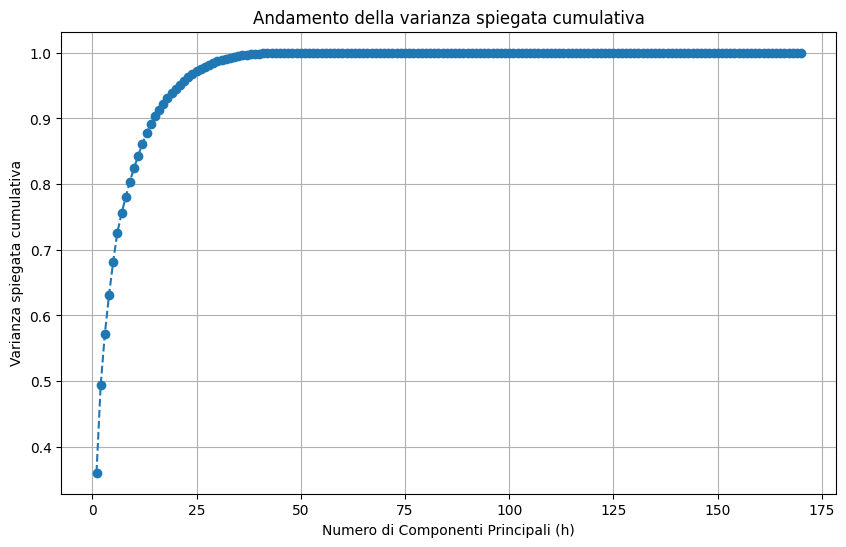

Varianza spiegata cumulativa per ogni h:
PC1: 0.3604
PC2: 0.4939
PC3: 0.5717
PC4: 0.6308
PC5: 0.6820
PC6: 0.7260
PC7: 0.7552
PC8: 0.7799
PC9: 0.8037
PC10: 0.8244
PC11: 0.8434
PC12: 0.8612
PC13: 0.8776
PC14: 0.8915
PC15: 0.9035
PC16: 0.9133
PC17: 0.9221
PC18: 0.9304
PC19: 0.9383
PC20: 0.9449
PC21: 0.9514
PC22: 0.9574
PC23: 0.9626
PC24: 0.9677
PC25: 0.9720
PC26: 0.9757
PC27: 0.9789
PC28: 0.9818
PC29: 0.9846
PC30: 0.9869
PC31: 0.9891
PC32: 0.9910
PC33: 0.9925
PC34: 0.9940
PC35: 0.9951
PC36: 0.9960
PC37: 0.9967
PC38: 0.9974
PC39: 0.9980
PC40: 0.9985
PC41: 0.9988
PC42: 0.9991
PC43: 0.9993
PC44: 0.9995
PC45: 0.9996
PC46: 0.9997
PC47: 0.9998
PC48: 0.9999
PC49: 0.9999
PC50: 1.0000
PC51: 1.0000
PC52: 1.0000
PC53: 1.0000
PC54: 1.0000
PC55: 1.0000
PC56: 1.0000
PC57: 1.0000
PC58: 1.0000
PC59: 1.0000
PC60: 1.0000
PC61: 1.0000
PC62: 1.0000
PC63: 1.0000
PC64: 1.0000
PC65: 1.0000
PC66: 1.0000
PC67: 1.0000
PC68: 1.0000
PC69: 1.0000
PC70: 1.0000
PC71: 1.0000
PC72: 1.0000
PC73: 1.0000
PC74: 1.0000
PC75: 

In [29]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


# Calcolare la varianza spiegata cumulativa
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()

# Visualizzare l'andamento della varianza spiegata
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Andamento della varianza spiegata cumulativa')
plt.xlabel('Numero di Componenti Principali (h)')
plt.ylabel('Varianza spiegata cumulativa')
plt.grid(True)
plt.show()

# Stampa dei dati della varianza spiegata cumulativa
print("Varianza spiegata cumulativa per ogni h:")
for k, variance in enumerate(cumulative_variance, start=1):
    print(f"PC{k}: {variance:.4f}")




In [30]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import numpy as np

# Imposta il seed per garantire la riproducibilità
SEED = 12456789
np.random.seed(SEED)

# Carichiamo il dataset con le componenti principali e la colonna target
dataset = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

# Creazione dei dataset per h = 5, 9, 15, 30
datasets_h = {}
for h in [5, 9, 15, 30,50]:
    features = [f'PC{i}' for i in range(1, h + 1)]
    datasets_h[h] = dataset[features + ['target']].dropna()

# Valori di k-fold da considerare
k_folds = [5, 7, 10]

# Addestramento e valutazione con k-fold cross-validation
results = {}
for h, data in datasets_h.items():
    results[h] = {}
    X = data.drop('target', axis=1).values
    y = data['target'].values

    for k in k_folds:
        mse_list = []
        r2_list = []

        # Inizializziamo il k-fold cross-validation
        kf = KFold(n_splits=k, shuffle=True, random_state=42)

        for train_index, test_index in kf.split(X):
            # Suddivisione in training e test set per ogni fold
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            # Addestramento del modello
            model = LinearRegression()
            model.fit(X_train, y_train)

            # Predizioni sul test set
            y_pred = model.predict(X_test)

            # Calcolo delle metriche
            mse_list.append(mean_squared_error(y_test, y_pred))
            r2_list.append(r2_score(y_test, y_pred))

        # Salviamo i risultati medi per ogni combinazione di h e k
        results[h][k] = {
            'MSE_mean': np.mean(mse_list),
            'MSE_std': np.std(mse_list),
            'R^2_mean': np.mean(r2_list),
            'R^2_std': np.std(r2_list),
        }

# Visualizziamo i risultati
for h, k_results in results.items():
    print(f"Risultati per h = {h}:")
    for k, res in k_results.items():
        print(f"  Con k-fold = {k}:")
        print(f"    MSE medio: {res['MSE_mean']:.4f} (std: {res['MSE_std']:.4f})")
        print(f"    R^2 medio: {res['R^2_mean']:.4f} (std: {res['R^2_std']:.4f})\n")


Risultati per h = 5:
  Con k-fold = 5:
    MSE medio: 1.1694 (std: 0.2219)
    R^2 medio: 0.6440 (std: 0.0580)

  Con k-fold = 7:
    MSE medio: 1.1762 (std: 0.3615)
    R^2 medio: 0.6316 (std: 0.0726)

  Con k-fold = 10:
    MSE medio: 1.1731 (std: 0.3695)
    R^2 medio: 0.6312 (std: 0.0969)

Risultati per h = 9:
  Con k-fold = 5:
    MSE medio: 0.9990 (std: 0.1142)
    R^2 medio: 0.6938 (std: 0.0437)

  Con k-fold = 7:
    MSE medio: 1.0625 (std: 0.2925)
    R^2 medio: 0.6666 (std: 0.0604)

  Con k-fold = 10:
    MSE medio: 1.0037 (std: 0.2605)
    R^2 medio: 0.6798 (std: 0.0892)

Risultati per h = 15:
  Con k-fold = 5:
    MSE medio: 0.8581 (std: 0.1155)
    R^2 medio: 0.7369 (std: 0.0425)

  Con k-fold = 7:
    MSE medio: 1.1443 (std: 0.7373)
    R^2 medio: 0.6536 (std: 0.1583)

  Con k-fold = 10:
    MSE medio: 0.8775 (std: 0.2420)
    R^2 medio: 0.7200 (std: 0.0802)

Risultati per h = 30:
  Con k-fold = 5:
    MSE medio: 0.4639 (std: 0.2254)
    R^2 medio: 0.8546 (std: 0.0760)

 

Colonne nel dataset delle componenti principali: Index(['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8', 'PC9', 'PC10',
       ...
       'PC162', 'PC163', 'PC164', 'PC165', 'PC166', 'PC167', 'PC168', 'PC169',
       'PC170', 'target'],
      dtype='object', length=171)
Colonne nel dataset filtrato dopo l'aggiunta della colonna target: Index(['NDG', 'Ragione sociale', 'Codice fiscale', 'Filiale', 'Ateco',
       'Ateco corrente', 'CAP', 'Comune', 'Indirizzo', 'Provincia',
       ...
       'Sensibilità', 'presente_in_ottimizzazione', 'presente_in_sviluppo',
       'presente_in_almeno_uno', 'presente_in_entrambi', 'data_input_sviluppo',
       'strategia_sviluppo', 'data_input_ottimizzazione',
       'strategia_ottimizzazione', 'target'],
      dtype='object', length=216)
Numero di righe con NaN nel target: 0
Numero massimo di componenti principali disponibili: 170
Feature con varianza troppo bassa: 
a. Sottoscritte da soci                                  0.0
a. Di cui ***      

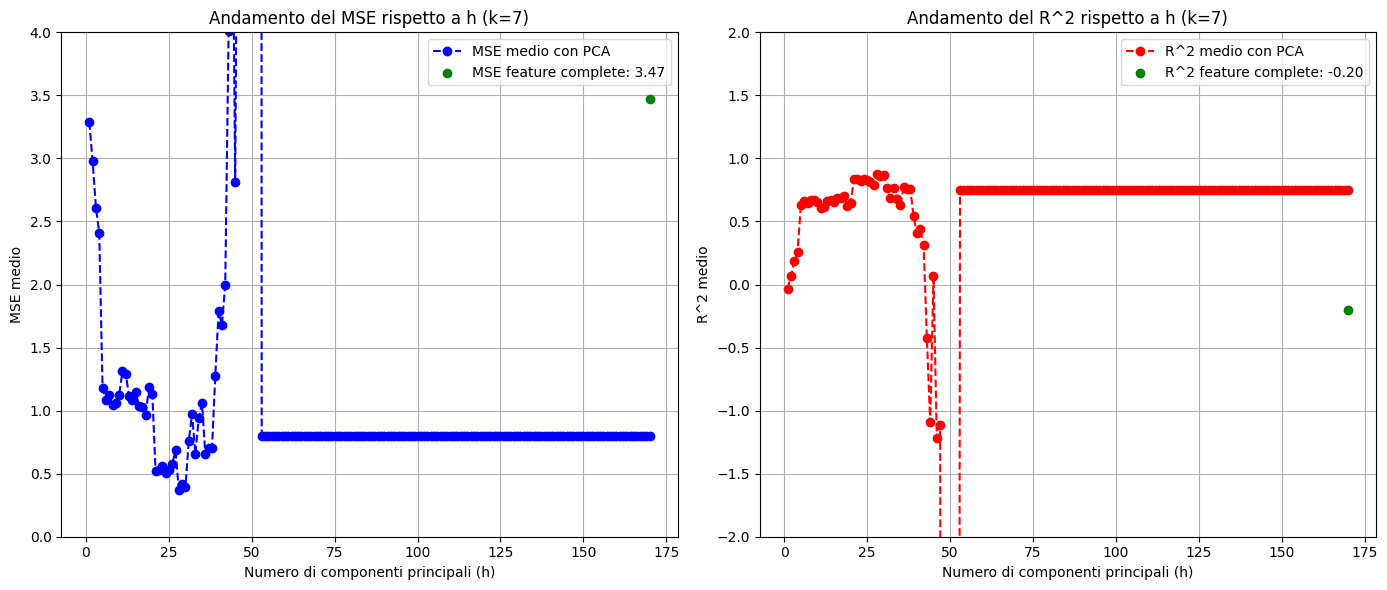

In [31]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore

# Imposta il seed per garantire la riproducibilità
SEED = 12456789
np.random.seed(SEED)

# Carica il dataset con le componenti principali e target
dataset_componenti_principali = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

# Controlla che la colonna 'target' sia presente
print(f"Colonne nel dataset delle componenti principali: {dataset_componenti_principali.columns}")

# Carica il dataset filtrato senza 'target'
dataset_filtrato = pd.read_csv('dataset_filtrato.csv')

# Aggiungi la colonna target dal dataset delle componenti principali senza una chiave
dataset_filtrato['target'] = dataset_componenti_principali['target']

# Verifica che ora il target sia nel dataset
print(f"Colonne nel dataset filtrato dopo l'aggiunta della colonna target: {dataset_filtrato.columns}")

# Verifica la presenza di NaN nel target
print(f"Numero di righe con NaN nel target: {dataset_filtrato['target'].isna().sum()}")

# Rimuovere le righe con target NaN
dataset_filtrato = dataset_filtrato.dropna(subset=['target'])

# Creazione del dataset per h = 1 fino a num_pc_available
dataset = pd.read_csv('dataset_con_target_e_componenti_principali.csv')
num_pc_available = sum(1 for col in dataset.columns if col.startswith('PC'))
print(f"Numero massimo di componenti principali disponibili: {num_pc_available}")

# Creazione dei dataset per h = 1 fino a num_pc_available
datasets_h = {}
for h in range(1, num_pc_available + 1):
    features = [f'PC{i}' for i in range(1, h + 1) if f'PC{i}' in dataset.columns]
    if features:
        datasets_h[h] = dataset[features + ['target']].dropna()

# Parametro k per la k-fold cross-validation
k = 7

# Addestramento e valutazione delle componenti principali
results = {}
for h, data in datasets_h.items():
    X = data.drop('target', axis=1).values
    y = data['target'].values

    mse_list = []
    r2_list = []

    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))

    mse_mean = np.mean(mse_list)
    r2_mean = np.mean(r2_list)

    results[h] = {
      'MSE_mean': mse_mean,
      'R^2_mean': r2_mean
    }

# Calcoliamo MSE e R² per il dataset delle feature filtrate
y_filtered = dataset_filtrato['target'].values  # Manteniamo 'target' qui, prima di qualsiasi modifica

# Seleziona solo le colonne numeriche, escludendo 'target'
dataset_filtrato = dataset_filtrato.select_dtypes(include=['float64', 'int64']).drop(columns=['NDG', 'Filiale', 'CAP', 'strategia_ottimizzazione', 'strategia_sviluppo', 'target'])

# Rilevazione degli outlier tramite Z-score
z_scores = np.abs(zscore(dataset_filtrato))  # Calcola il Z-score per le righe
outliers = (z_scores > 3).all(axis=1)  # Identifica le righe con outlier (Z-score > 3)
dataset_filtrato = dataset_filtrato[~outliers]  # Rimuove le righe con outlier

# Calcola la varianza delle feature originali (prima della PCA)
feature_variance = dataset_filtrato.var().sort_values()

# Visualizza le feature con varianza bassa (es. < 0.01)
low_variance_features = feature_variance[feature_variance < 0.01]
print("Feature con varianza troppo bassa: ")
print(low_variance_features)

# Rimuovi le feature con varianza troppo bassa
dataset_filtrato = dataset_filtrato.drop(columns=low_variance_features.index)
# Visualizza il numero di feature nel dataset filtrato
num_feature_filtered = dataset_filtrato.shape[1]
print(f"Numero di feature nel dataset filtrato: {num_feature_filtered}")

# Ora, possiamo preparare X_filtered
X_filtered = dataset_filtrato.values

# K-Fold Cross-Validation per il dataset filtrato
mse_filtered_list = []
r2_filtered_list = []

kf = KFold(n_splits=k, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_filtered):
    X_train, X_test = X_filtered[train_index], X_filtered[test_index]
    y_train, y_test = y_filtered[train_index], y_filtered[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_filtered_list.append(mean_squared_error(y_test, y_pred))
    r2_filtered_list.append(r2_score(y_test, y_pred))

mse_filtered_mean = np.mean(mse_filtered_list)
r2_filtered_mean = np.mean(r2_filtered_list)

# Estraiamo i risultati per MSE e R²
h_values = list(results.keys())
mse_means = np.array([results[h]['MSE_mean'] for h in h_values], dtype=float)
r2_means = np.array([results[h]['R^2_mean'] for h in h_values], dtype=float)

# Creazione dei grafici
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafico MSE
axes[0].plot(h_values, mse_means, linestyle='--', color='blue', marker='o', label='MSE medio con PCA')
axes[0].scatter(num_pc_available, mse_filtered_mean, color='green', zorder=5, label=f'MSE feature complete: {mse_filtered_mean:.2f}')  # Punti singoli per MSE alla posizione h_max
axes[0].set_title("Andamento del MSE rispetto a h (k=7)")
axes[0].set_xlabel("Numero di componenti principali (h)")
axes[0].set_ylabel("MSE medio")
axes[0].set_ylim(0, 4)  # Imposta l'intervallo per visualizzare
axes[0].legend()
axes[0].grid()

# Grafico R^2
axes[1].plot(h_values, r2_means, linestyle='--', color='red', marker='o', label='R^2 medio con PCA')
axes[1].scatter(num_pc_available, r2_filtered_mean, color='green', zorder=5, label=f'R^2 feature complete: {r2_filtered_mean:.2f}')  # Punti singoli per R^2 alla posizione h_max
axes[1].set_title("Andamento del R^2 rispetto a h (k=7)")
axes[1].set_xlabel("Numero di componenti principali (h)")
axes[1].set_ylabel("R^2 medio")
axes[1].set_ylim(-2, 2)  # Imposta l'intervallo per visualizzare
axes[1].legend()
axes[1].grid()

plt.tight_layout()
plt.show()


Feature complete utilizzate nel modello: ['A) Cred. v/soci per versamenti dovuti', 'X. Crediti vs soci per versamenti dovuti generici', 'B) Immobilizzazioni', 'I. Immobilizzazioni immateriali', 'X. Immobilizzazioni immateriali generiche', 'II. Immobilizzazioni materiali', '1. Terreni e fabbricati', 'Altri beni', '5. Immobilizzazioni in corso e acconti', 'X. Immobilizzazioni materiali generiche', 'III. Immobilizzazioni finanziarie', '1. Partecipazioni in:', 'X. Partecipazioni generiche', 'X. Crediti e titoli generici', 'C) Attivo circolante', 'I. Rimanenze', '1. Materie prime, sussidiarie e di consumo', '2. Prodotti in corso di lavorazione e semilavorati', '5. Acconti', 'X. Rimanenze generiche', 'II. Crediti', '1. Crediti v/ clienti', "a) crediti vs clienti entro l'esercizio", "X. Crediti generici entro l'esercizio", 'III. Attivitá finanziarie che non costituiscono immobilizzazioni', 'X. Attività finanziarie non immobilizzate generiche', 'IV. Disponibilitá liquide', 'X. Disponibilità li

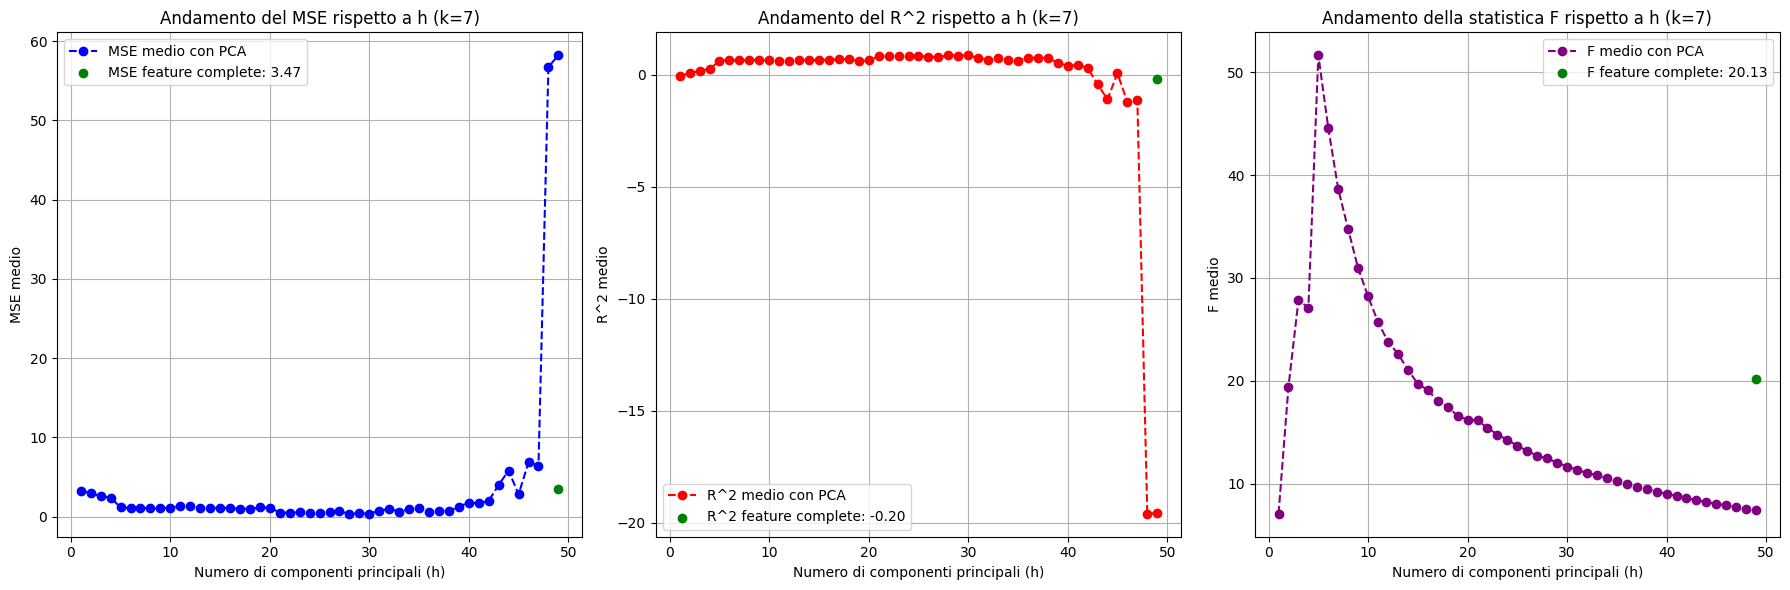

In [32]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression
from scipy.stats import zscore

# Imposta il seed per garantire la riproducibilità
SEED = 12456789
np.random.seed(SEED)

# Carica il dataset con le componenti principali e target
dataset_componenti_principali = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

dataset_filtrato = pd.read_csv('dataset_filtrato.csv')
dataset_filtrato['target'] = dataset_componenti_principali['target']
dataset_filtrato = dataset_filtrato.dropna(subset=['target'])

num_pc_available = sum(1 for col in dataset_componenti_principali.columns if col.startswith('PC'))

# Creazione dei dataset per h = 1 fino a num_pc_available
datasets_h = {}
for h in range(1, 50):
    features = [f'PC{i}' for i in range(1, h + 1) if f'PC{i}' in dataset_componenti_principali.columns]
    if features:
        datasets_h[h] = dataset_componenti_principali[features + ['target']].dropna()

# Parametro k per la k-fold cross-validation
k = 7

# Addestramento e valutazione delle componenti principali
results = {}
for h, data in datasets_h.items():
    X = data.drop('target', axis=1).values
    y = data['target'].values

    mse_list, r2_list, f_list = [], [], []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
        f_value, _ = f_regression(X_train, y_train)
        f_list.append(np.mean(f_value))

    results[h] = {
        'MSE_mean': np.mean(mse_list),
        'R^2_mean': np.mean(r2_list),
        'F_mean': np.mean(f_list)
    }

# Calcoliamo per il dataset delle feature complete
y_filtered = dataset_filtrato['target'].values
dataset_filtrato = dataset_filtrato.select_dtypes(include=['float64', 'int64']).drop(columns=['NDG', 'Filiale', 'CAP', 'strategia_ottimizzazione', 'strategia_sviluppo', 'target'])

dataset_filtrato = dataset_filtrato[~(np.abs(zscore(dataset_filtrato)) > 3).all(axis=1)]
dataset_filtrato = dataset_filtrato.drop(columns=dataset_filtrato.var()[dataset_filtrato.var() < 0.01].index)
X_filtered = dataset_filtrato.values
print("Feature complete utilizzate nel modello:", dataset_filtrato.columns.tolist())


mse_filtered_list, r2_filtered_list, f_filtered_list = [], [], []
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_filtered):
    X_train, X_test = X_filtered[train_index], X_filtered[test_index]
    y_train, y_test = y_filtered[train_index], y_filtered[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_filtered_list.append(mean_squared_error(y_test, y_pred))
    r2_filtered_list.append(r2_score(y_test, y_pred))
    f_value, _ = f_regression(X_train, y_train)
    f_filtered_list.append(np.mean(f_value))

mse_filtered_mean = np.mean(mse_filtered_list)
r2_filtered_mean = np.mean(r2_filtered_list)
f_filtered_mean = np.mean(f_filtered_list)

# Estraiamo i risultati per i grafici
h_values = list(results.keys())
mse_means = np.array([results[h]['MSE_mean'] for h in h_values], dtype=float)
r2_means = np.array([results[h]['R^2_mean'] for h in h_values], dtype=float)
f_means = np.array([results[h]['F_mean'] for h in h_values], dtype=float)

# Creazione dei grafici
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Grafico MSE
axes[0].plot(h_values, mse_means, linestyle='--', color='blue', marker='o', label='MSE medio con PCA')
axes[0].scatter(49, mse_filtered_mean, color='green', zorder=5, label=f'MSE feature complete: {mse_filtered_mean:.2f}')
axes[0].set_title("Andamento del MSE rispetto a h (k=7)")
axes[0].set_xlabel("Numero di componenti principali (h)")
axes[0].set_ylabel("MSE medio")
axes[0].legend()
axes[0].grid()

# Grafico R^2
axes[1].plot(h_values, r2_means, linestyle='--', color='red', marker='o', label='R^2 medio con PCA')
axes[1].scatter(49, r2_filtered_mean, color='green', zorder=5, label=f'R^2 feature complete: {r2_filtered_mean:.2f}')
axes[1].set_title("Andamento del R^2 rispetto a h (k=7)")
axes[1].set_xlabel("Numero di componenti principali (h)")
axes[1].set_ylabel("R^2 medio")
axes[1].legend()
axes[1].grid()

# Grafico F
axes[2].plot(h_values, f_means, linestyle='--', color='purple', marker='o', label='F medio con PCA')
axes[2].scatter(49, f_filtered_mean, color='green', zorder=5, label=f'F feature complete: {f_filtered_mean:.2f}')
axes[2].set_title("Andamento della statistica F rispetto a h (k=7)")
axes[2].set_xlabel("Numero di componenti principali (h)")
axes[2].set_ylabel("F medio")
axes[2].legend()
axes[2].grid()

plt.tight_layout()
plt.show()


Feature complete utilizzate nel modello: ['A) Cred. v/soci per versamenti dovuti', 'X. Crediti vs soci per versamenti dovuti generici', 'B) Immobilizzazioni', 'I. Immobilizzazioni immateriali', 'X. Immobilizzazioni immateriali generiche', 'II. Immobilizzazioni materiali', '1. Terreni e fabbricati', 'Altri beni', '5. Immobilizzazioni in corso e acconti', 'X. Immobilizzazioni materiali generiche', 'III. Immobilizzazioni finanziarie', '1. Partecipazioni in:', 'X. Partecipazioni generiche', 'X. Crediti e titoli generici', 'C) Attivo circolante', 'I. Rimanenze', '1. Materie prime, sussidiarie e di consumo', '2. Prodotti in corso di lavorazione e semilavorati', '5. Acconti', 'X. Rimanenze generiche', 'II. Crediti', '1. Crediti v/ clienti', "a) crediti vs clienti entro l'esercizio", "X. Crediti generici entro l'esercizio", 'III. Attivitá finanziarie che non costituiscono immobilizzazioni', 'X. Attività finanziarie non immobilizzate generiche', 'IV. Disponibilitá liquide', 'X. Disponibilità li

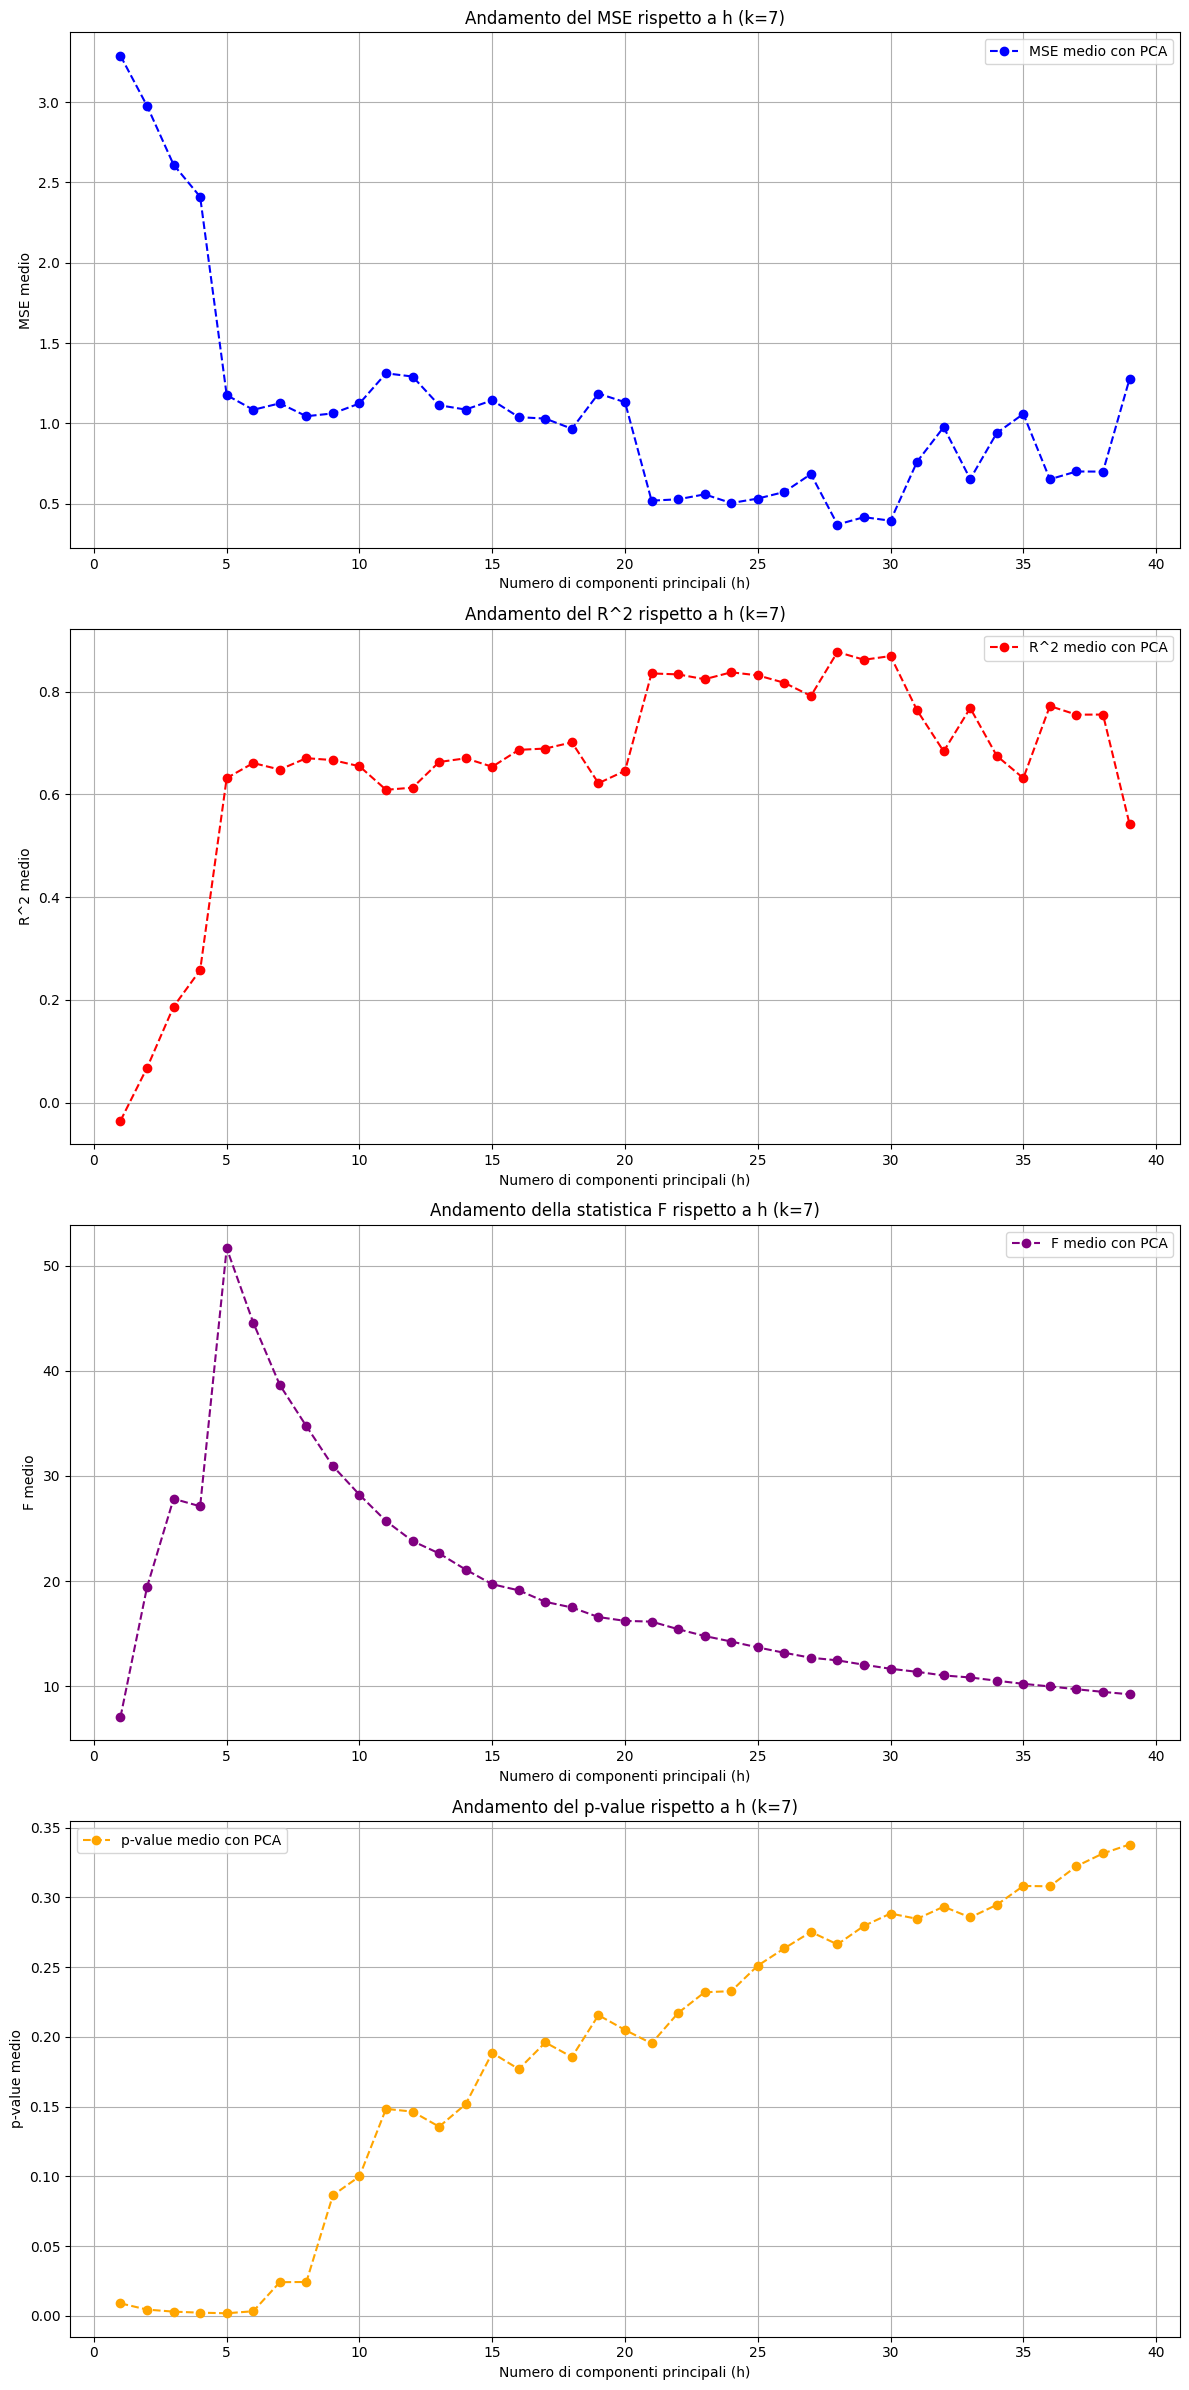

In [33]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression
from scipy.stats import zscore

# Imposta il seed per garantire la riproducibilità
SEED = 12456789
np.random.seed(SEED)

# Carica il dataset con le componenti principali e target
dataset_componenti_principali = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

dataset_filtrato = pd.read_csv('dataset_filtrato.csv')
dataset_filtrato['target'] = dataset_componenti_principali['target']
dataset_filtrato = dataset_filtrato.dropna(subset=['target'])

num_pc_available = sum(1 for col in dataset_componenti_principali.columns if col.startswith('PC'))

# Creazione dei dataset per h = 1 fino a num_pc_available
datasets_h = {}
for h in range(1, 40):
    features = [f'PC{i}' for i in range(1, h + 1) if f'PC{i}' in dataset_componenti_principali.columns]
    if features:
        datasets_h[h] = dataset_componenti_principali[features + ['target']].dropna()

# Parametro k per la k-fold cross-validation
k = 7

# Addestramento e valutazione delle componenti principali
results = {}
for h, data in datasets_h.items():
    X = data.drop('target', axis=1).values
    y = data['target'].values

    mse_list, r2_list, f_list, p_value_list = [], [], [], []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
        f_value, p_value = f_regression(X_train, y_train)
        f_list.append(np.mean(f_value))
        p_value_list.append(np.mean(p_value))

    results[h] = {
        'MSE_mean': np.mean(mse_list),
        'R^2_mean': np.mean(r2_list),
        'F_mean': np.mean(f_list),
        'p_value_mean': np.mean(p_value_list)
    }

# Calcoliamo per il dataset delle feature complete
y_filtered = dataset_filtrato['target'].values
dataset_filtrato = dataset_filtrato.select_dtypes(include=['float64', 'int64']).drop(columns=['NDG', 'Filiale', 'CAP', 'strategia_ottimizzazione', 'strategia_sviluppo', 'target'])

dataset_filtrato = dataset_filtrato[~(np.abs(zscore(dataset_filtrato)) > 3).all(axis=1)]
dataset_filtrato = dataset_filtrato.drop(columns=dataset_filtrato.var()[dataset_filtrato.var() < 0.01].index)
X_filtered = dataset_filtrato.values
print("Feature complete utilizzate nel modello:", dataset_filtrato.columns.tolist())

mse_filtered_list, r2_filtered_list, f_filtered_list, p_filtered_list = [], [], [], []
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_filtered):
    X_train, X_test = X_filtered[train_index], X_filtered[test_index]
    y_train, y_test = y_filtered[train_index], y_filtered[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_filtered_list.append(mean_squared_error(y_test, y_pred))
    r2_filtered_list.append(r2_score(y_test, y_pred))
    f_value, p_value = f_regression(X_train, y_train)
    f_filtered_list.append(np.mean(f_value))
    p_filtered_list.append(np.mean(p_value))

mse_filtered_mean = np.mean(mse_filtered_list)
r2_filtered_mean = np.mean(r2_filtered_list)
f_filtered_mean = np.mean(f_filtered_list)
p_filtered_mean = np.mean(p_filtered_list)

# Estraiamo i risultati per i grafici
h_values = list(results.keys())
mse_means = np.array([results[h]['MSE_mean'] for h in h_values], dtype=float)
r2_means = np.array([results[h]['R^2_mean'] for h in h_values], dtype=float)
f_means = np.array([results[h]['F_mean'] for h in h_values], dtype=float)
p_values = np.array([results[h]['p_value_mean'] for h in h_values], dtype=float)

# Creazione dei grafici (disposti verticalmente)
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# Grafico MSE
axes[0].plot(h_values, mse_means, linestyle='--', color='blue', marker='o', label='MSE medio con PCA')
#axes[0].scatter(39, mse_filtered_mean, color='green', zorder=5, label=f'MSE feature complete: {mse_filtered_mean:.2f}')
axes[0].set_title("Andamento del MSE rispetto a h (k=7)")
axes[0].set_xlabel("Numero di componenti principali (h)")
axes[0].set_ylabel("MSE medio")
axes[0].legend()
axes[0].grid()

# Grafico R^2
axes[1].plot(h_values, r2_means, linestyle='--', color='red', marker='o', label='R^2 medio con PCA')
#axes[1].scatter(39, r2_filtered_mean, color='green', zorder=5, label=f'R^2 feature complete: {r2_filtered_mean:.2f}')
axes[1].set_title("Andamento del R^2 rispetto a h (k=7)")
axes[1].set_xlabel("Numero di componenti principali (h)")
axes[1].set_ylabel("R^2 medio")
axes[1].legend()
axes[1].grid()

# Grafico F
axes[2].plot(h_values, f_means, linestyle='--', color='purple', marker='o', label='F medio con PCA')
#axes[2].scatter(39, f_filtered_mean, color='green', zorder=5, label=f'F feature complete: {f_filtered_mean:.2f}')
axes[2].set_title("Andamento della statistica F rispetto a h (k=7)")
axes[2].set_xlabel("Numero di componenti principali (h)")
axes[2].set_ylabel("F medio")
axes[2].legend()
axes[2].grid()

# Grafico p-value
axes[3].plot(h_values, p_values, linestyle='--', color='orange', marker='o', label='p-value medio con PCA')
#axes[3].scatter(39, p_filtered_mean, color='green', zorder=5, label=f'p-value feature complete: {p_filtered_mean:.2f}')
axes[3].set_title("Andamento del p-value rispetto a h (k=7)")
axes[3].set_xlabel("Numero di componenti principali (h)")
axes[3].set_ylabel("p-value medio")
axes[3].legend()
axes[3].grid()

plt.tight_layout()
plt.show()


Feature complete utilizzate nel modello: ['A) Cred. v/soci per versamenti dovuti', 'X. Crediti vs soci per versamenti dovuti generici', 'B) Immobilizzazioni', 'I. Immobilizzazioni immateriali', 'X. Immobilizzazioni immateriali generiche', 'II. Immobilizzazioni materiali', '1. Terreni e fabbricati', 'Altri beni', '5. Immobilizzazioni in corso e acconti', 'X. Immobilizzazioni materiali generiche', 'III. Immobilizzazioni finanziarie', '1. Partecipazioni in:', 'X. Partecipazioni generiche', 'X. Crediti e titoli generici', 'C) Attivo circolante', 'I. Rimanenze', '1. Materie prime, sussidiarie e di consumo', '2. Prodotti in corso di lavorazione e semilavorati', '5. Acconti', 'X. Rimanenze generiche', 'II. Crediti', '1. Crediti v/ clienti', "a) crediti vs clienti entro l'esercizio", "X. Crediti generici entro l'esercizio", 'III. Attivitá finanziarie che non costituiscono immobilizzazioni', 'X. Attività finanziarie non immobilizzate generiche', 'IV. Disponibilitá liquide', 'X. Disponibilità li

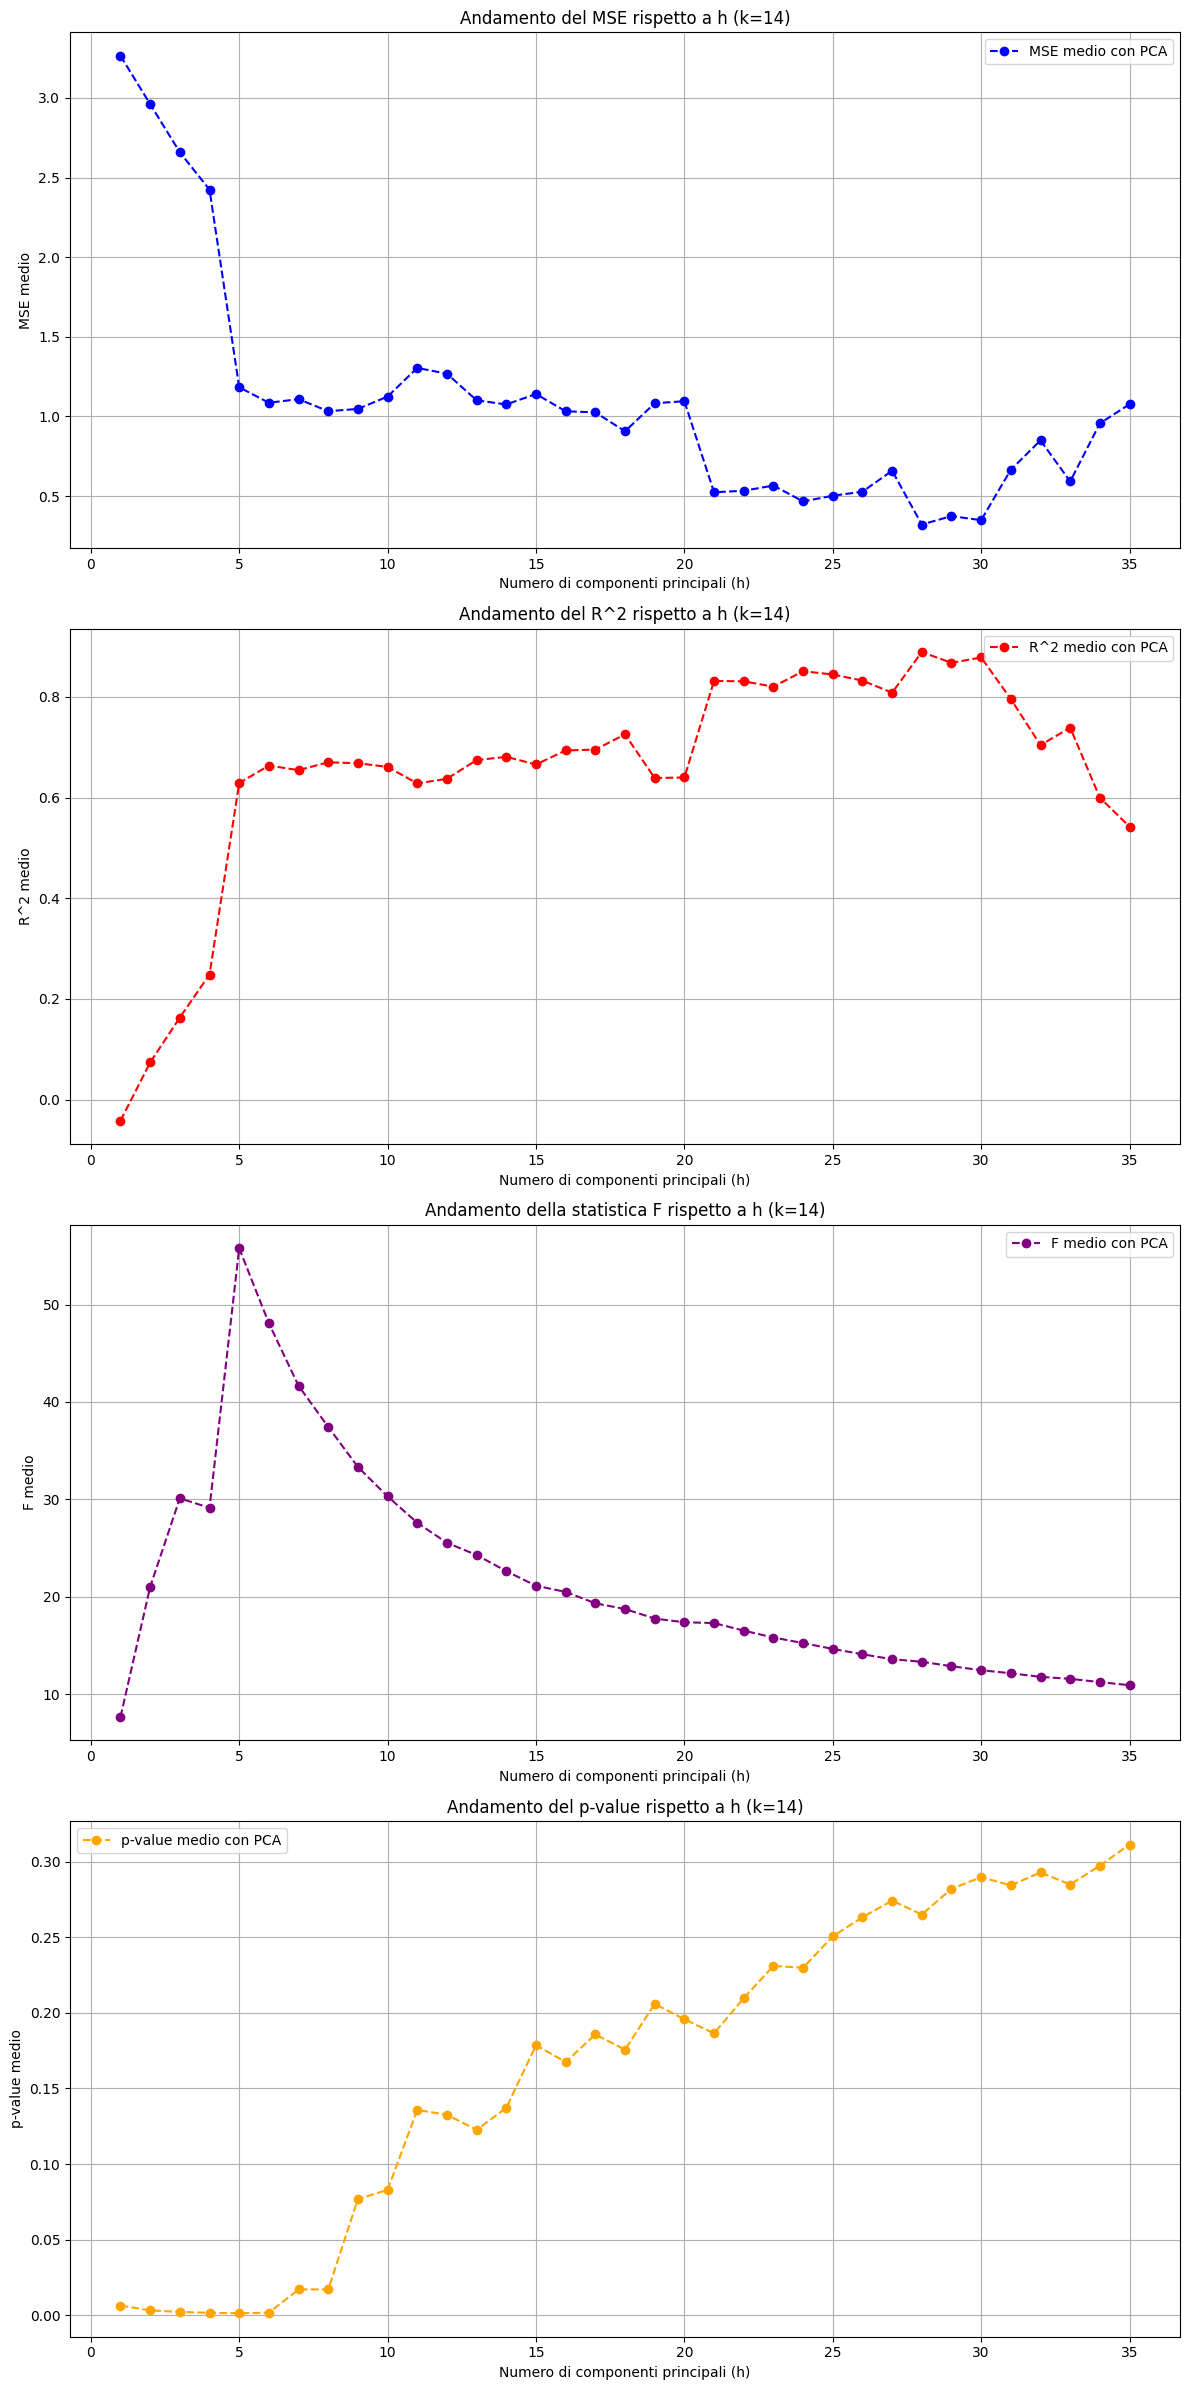

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import f_regression
from scipy.stats import zscore

# Imposta il seed per garantire la riproducibilità
SEED = 12456789
np.random.seed(SEED)

# Carica il dataset con le componenti principali e target
dataset_componenti_principali = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

dataset_filtrato = pd.read_csv('dataset_filtrato.csv')
dataset_filtrato['target'] = dataset_componenti_principali['target']
dataset_filtrato = dataset_filtrato.dropna(subset=['target'])

num_pc_available = sum(1 for col in dataset_componenti_principali.columns if col.startswith('PC'))

# Creazione dei dataset per h = 1 fino a num_pc_available
datasets_h = {}
for h in range(1, 36):
    features = [f'PC{i}' for i in range(1, h + 1) if f'PC{i}' in dataset_componenti_principali.columns]
    if features:
        datasets_h[h] = dataset_componenti_principali[features + ['target']].dropna()

# Parametro k per la k-fold cross-validation
k = 14

# Addestramento e valutazione delle componenti principali
results = {}
for h, data in datasets_h.items():
    X = data.drop('target', axis=1).values
    y = data['target'].values

    mse_list, r2_list, f_list, p_value_list = [], [], [], []
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse_list.append(mean_squared_error(y_test, y_pred))
        r2_list.append(r2_score(y_test, y_pred))
        f_value, p_value = f_regression(X_train, y_train)
        f_list.append(np.mean(f_value))
        p_value_list.append(np.mean(p_value))

    results[h] = {
        'MSE_mean': np.mean(mse_list),
        'R^2_mean': np.mean(r2_list),
        'F_mean': np.mean(f_list),
        'p_value_mean': np.mean(p_value_list)
    }

# Calcoliamo per il dataset delle feature complete
y_filtered = dataset_filtrato['target'].values
dataset_filtrato = dataset_filtrato.select_dtypes(include=['float64', 'int64']).drop(columns=['NDG', 'Filiale', 'CAP', 'strategia_ottimizzazione', 'strategia_sviluppo', 'target'])

dataset_filtrato = dataset_filtrato[~(np.abs(zscore(dataset_filtrato)) > 3).all(axis=1)]
dataset_filtrato = dataset_filtrato.drop(columns=dataset_filtrato.var()[dataset_filtrato.var() < 0.01].index)
X_filtered = dataset_filtrato.values
print("Feature complete utilizzate nel modello:", dataset_filtrato.columns.tolist())

mse_filtered_list, r2_filtered_list, f_filtered_list, p_filtered_list = [], [], [], []
kf = KFold(n_splits=k, shuffle=True, random_state=42)
for train_index, test_index in kf.split(X_filtered):
    X_train, X_test = X_filtered[train_index], X_filtered[test_index]
    y_train, y_test = y_filtered[train_index], y_filtered[test_index]

    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse_filtered_list.append(mean_squared_error(y_test, y_pred))
    r2_filtered_list.append(r2_score(y_test, y_pred))
    f_value, p_value = f_regression(X_train, y_train)
    f_filtered_list.append(np.mean(f_value))
    p_filtered_list.append(np.mean(p_value))

mse_filtered_mean = np.mean(mse_filtered_list)
r2_filtered_mean = np.mean(r2_filtered_list)
f_filtered_mean = np.mean(f_filtered_list)
p_filtered_mean = np.mean(p_filtered_list)

# Estraiamo i risultati per i grafici
h_values = list(results.keys())
mse_means = np.array([results[h]['MSE_mean'] for h in h_values], dtype=float)
r2_means = np.array([results[h]['R^2_mean'] for h in h_values], dtype=float)
f_means = np.array([results[h]['F_mean'] for h in h_values], dtype=float)
p_values = np.array([results[h]['p_value_mean'] for h in h_values], dtype=float)

# Creazione dei grafici (disposti verticalmente)
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# Grafico MSE
axes[0].plot(h_values, mse_means, linestyle='--', color='blue', marker='o', label='MSE medio con PCA')
#axes[0].scatter(39, mse_filtered_mean, color='green', zorder=5, label=f'MSE feature complete: {mse_filtered_mean:.2f}')
axes[0].set_title("Andamento del MSE rispetto a h (k=14)")
axes[0].set_xlabel("Numero di componenti principali (h)")
axes[0].set_ylabel("MSE medio")
axes[0].legend()
axes[0].grid()

# Grafico R^2
axes[1].plot(h_values, r2_means, linestyle='--', color='red', marker='o', label='R^2 medio con PCA')
#axes[1].scatter(39, r2_filtered_mean, color='green', zorder=5, label=f'R^2 feature complete: {r2_filtered_mean:.2f}')
axes[1].set_title("Andamento del R^2 rispetto a h (k=14)")
axes[1].set_xlabel("Numero di componenti principali (h)")
axes[1].set_ylabel("R^2 medio")
axes[1].legend()
axes[1].grid()

# Grafico F
axes[2].plot(h_values, f_means, linestyle='--', color='purple', marker='o', label='F medio con PCA')
#axes[2].scatter(39, f_filtered_mean, color='green', zorder=5, label=f'F feature complete: {f_filtered_mean:.2f}')
axes[2].set_title("Andamento della statistica F rispetto a h (k=14)")
axes[2].set_xlabel("Numero di componenti principali (h)")
axes[2].set_ylabel("F medio")
axes[2].legend()
axes[2].grid()

# Grafico p-value
axes[3].plot(h_values, p_values, linestyle='--', color='orange', marker='o', label='p-value medio con PCA')
#axes[3].scatter(39, p_filtered_mean, color='green', zorder=5, label=f'p-value feature complete: {p_filtered_mean:.2f}')
axes[3].set_title("Andamento del p-value rispetto a h (k=14)")
axes[3].set_xlabel("Numero di componenti principali (h)")
axes[3].set_ylabel("p-value medio")
axes[3].legend()
axes[3].grid()

plt.tight_layout()
plt.show()


In [35]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
# Imposta il seed per garantire la riproducibilità
SEED = 12456789
np.random.seed(SEED)

# Carica il dataset con le componenti principali e target
dataset_componenti_principali = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

dataset_filtrato = pd.read_csv('dataset_filtrato.csv')
dataset_filtrato['target'] = dataset_componenti_principali['target']
dataset_filtrato = dataset_filtrato.dropna(subset=['target'])
# Scegliamo h = 5, quindi selezioniamo le prime 5 componenti principali
h = 5
features = [f'PC{i}' for i in range(1, h + 1) if f'PC{i}' in dataset_componenti_principali.columns]

# Selezioniamo le variabili X (features) e y (target) per il modello di regressione
X = dataset_componenti_principali[features].values
y = dataset_filtrato['target'].values

# Aggiungiamo una colonna di 1 per il termine di intercetta
X = np.column_stack((np.ones(X.shape[0]), X))  # Aggiunge una colonna di 1 per l'intercetta

# Creiamo il modello di regressione lineare
model = LinearRegression()
model.fit(X, y)

# Estraiamo i coefficienti stimati
coefficients = model.coef_

# Calcoliamo le previsioni per il training set
y_pred = model.predict(X)

# Calcoliamo l'errore quadratico medio (MSE)
mse = mean_squared_error(y, y_pred)

# Calcoliamo la varianza dei residui
residuals = y - y_pred
residual_variance = np.var(residuals)

# Calcoliamo l'errore standard dei coefficienti
X_transpose = X.T
X_inv = np.linalg.inv(X_transpose @ X)
stderr_coefficients = np.sqrt(residual_variance * np.diagonal(X_inv))

# Calcoliamo i t-statistic per ogni coefficiente
t_stats = coefficients / stderr_coefficients

# Calcoliamo i p-value associati ai t-statistic (con un test a due code)
p_values = [2 * (1 - stats.t.cdf(np.abs(t_stat), df=X.shape[0] - len(features) - 1)) for t_stat in t_stats]

# Creiamo un DataFrame per visualizzare i risultati
results = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': stderr_coefficients,
    't-statistic': t_stats,
    'p-value': p_values
}, index=['Intercept'] + features)

# Mostriamo i risultati
print(results)


           Coefficient  Standard Error  t-statistic       p-value
Intercept     0.000000        0.056992     0.000000  1.000000e+00
PC1           0.035380        0.007281     4.859470  1.793959e-06
PC2          -0.118373        0.011966    -9.892611  0.000000e+00
PC3           0.180116        0.015665    11.498058  0.000000e+00
PC4          -0.156499        0.017991    -8.698948  2.220446e-16
PC5          -0.356663        0.019307   -18.473440  0.000000e+00


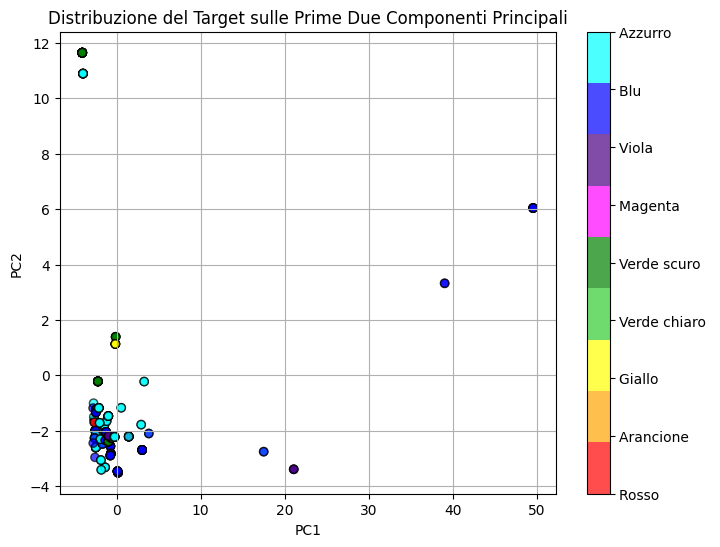

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap

# Carica il dataset
dataset = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

# Seleziona le prime due componenti principali e il target
pc1 = dataset['PC1']
pc2 = dataset['PC2']
target = dataset['target']

# Definizione dei colori con Azzurro per il valore più alto e Rosso per il più basso
colori = [
    "#ff0000",  # 1 - Rosso 🔴
    "#ffa500",  # 2 - Arancione 🟠
    "#ffff00",  # 3 - Giallo 🟡
    "#32CD32",  # 4 - Verde chiaro 💚
    "#008000",  # 5 - Verde scuro 🟢
    "#ff00ff",  # 6 - Magenta 💜
    "#4B0082",  # 7 - Viola 🟣
    "#0000ff",  # 8 - Blu 🔷
    "#00ffff"   # 9 - Azzurro 🔵
]

# Crea una colormap personalizzata con i colori definiti
custom_cmap = ListedColormap(colori)

# Crea il grafico a dispersione
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=target, cmap=custom_cmap, edgecolors='k', alpha=0.7, vmin=1, vmax=9)

# Aggiungi una barra dei colori
cbar = plt.colorbar(scatter, ticks=range(1, 10))

# Imposta le etichette della barra dei colori
cbar.ax.set_yticklabels([
    "Rosso ", "Arancione ", "Giallo ", "Verde chiaro ",
    "Verde scuro ", "Magenta ", "Viola ", "Blu ", "Azzurro "
])

# Etichette e titolo
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Distribuzione del Target sulle Prime Due Componenti Principali')
plt.grid(True)

# Mostra il grafico
plt.show()


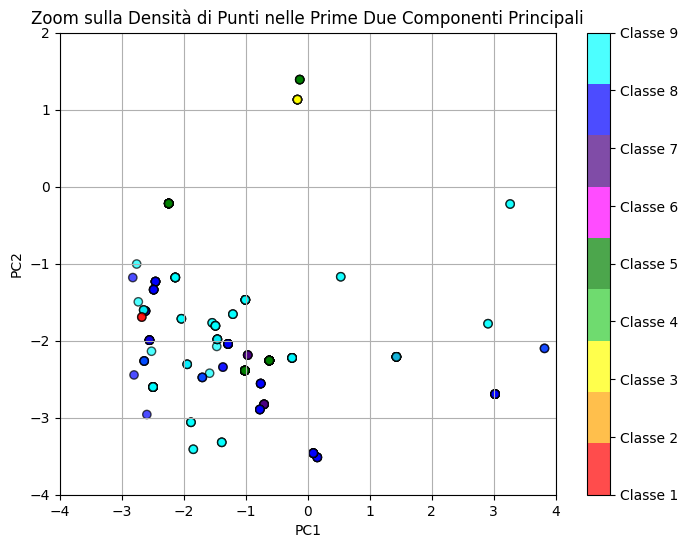

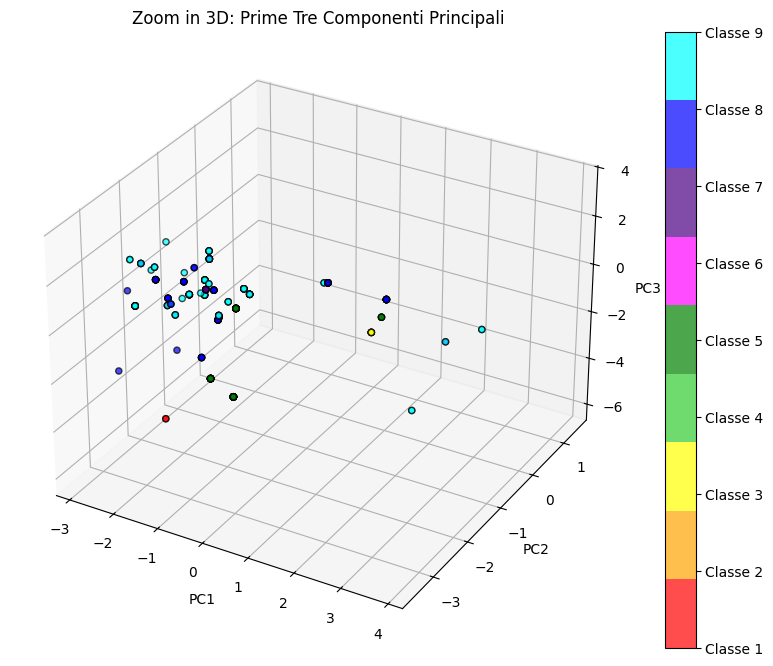

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D  # Import per il grafico 3D

# Carica il dataset
dataset = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

# Seleziona le prime tre componenti principali e il target
pc1 = dataset['PC1']
pc2 = dataset['PC2']
pc3 = dataset['PC3']  # Terza componente principale
target = dataset['target']

# Definisci 9 colori distinti con la classe 3 in marrone
colori = [
    "#ff0000",  # 1 - Rosso 🔴
    "#ffa500",  # 2 - Arancione 🟠
    "#ffff00",  # 3 - Giallo 🟡
    "#32CD32",  # 4 - Verde chiaro 💚
    "#008000",  # 5 - Verde scuro 🟢
    "#ff00ff",  # 6 - Magenta 💜
    "#4B0082",  # 7 - Viola 🟣
    "#0000ff",  # 8 - Blu 🔷
    "#00ffff"   # 9 - Azzurro 🔵
]

# Crea una colormap personalizzata con i 9 colori
custom_cmap = ListedColormap(colori)

### GRAFICO 2D CON ZOOM ###
plt.figure(figsize=(8, 6))
scatter = plt.scatter(pc1, pc2, c=target, cmap=custom_cmap, edgecolors='k', alpha=0.7, vmin=1, vmax=9)

# Aggiungi una barra dei colori
cbar = plt.colorbar(scatter, ticks=range(1, 10))
cbar.ax.set_yticklabels([f"Classe {i}" for i in range(1, 10)])

# Imposta lo zoom sugli assi
plt.xlim(-4, 4)  # Limiti per PC1
plt.ylim(-4, 2)   # Limiti per PC2

# Etichette e titolo
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Zoom sulla Densità di Punti nelle Prime Due Componenti Principali')
plt.grid(True)

# Mostra il grafico 2D
plt.show()


### GRAFICO 3D SOLO ZONA ZOOMATA ###
# Filtra i dati per mantenere solo la regione zoomata
mask_zoom = (pc1 >= -4) & (pc1 <= 4) & (pc2 >= -4) & (pc2 <= 2) & (pc3 >= -7) & (pc3 <= 4)

pc1_zoom = pc1[mask_zoom]
pc2_zoom = pc2[mask_zoom]
pc3_zoom = pc3[mask_zoom]
target_zoom = target[mask_zoom]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Disegna il grafico 3D solo con i dati filtrati
scatter3d = ax.scatter(pc1_zoom, pc2_zoom, pc3_zoom, c=target_zoom, cmap=custom_cmap, edgecolors='k', alpha=0.7, vmin=1, vmax=9)

# Etichette degli assi
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('Zoom in 3D: Prime Tre Componenti Principali')

# Aggiungi una barra dei colori
cbar = plt.colorbar(scatter3d, ticks=range(1, 10))
cbar.ax.set_yticklabels([f"Classe {i}" for i in range(1, 10)])

# Mostra il grafico 3D
plt.show()


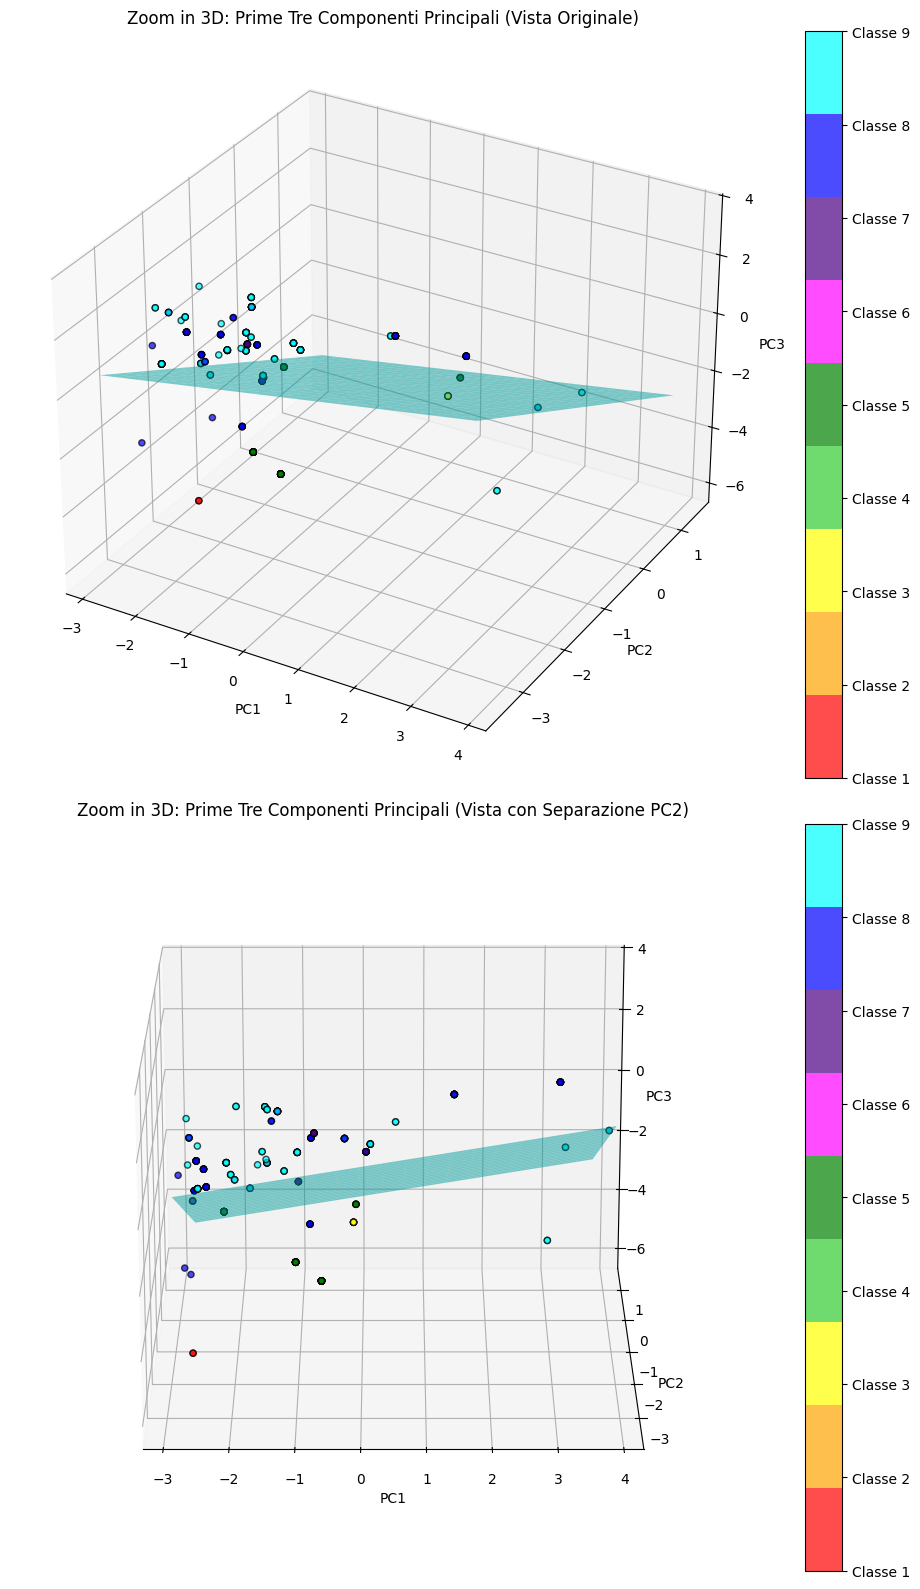

In [45]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression

# Carica il dataset
dataset = pd.read_csv('dataset_con_target_e_componenti_principali.csv')

# Seleziona le prime tre componenti principali e il target
pc1 = dataset['PC1']
pc2 = dataset['PC2']
pc3 = dataset['PC3']
target = dataset['target']

# Definisci 9 colori distinti
colori = [
    "#ff0000", "#ffa500", "#ffff00", "#32CD32", "#008000",
    "#ff00ff", "#4B0082", "#0000ff", "#00ffff"
]
custom_cmap = ListedColormap(colori)

# Filtra i dati per mantenere solo la regione zoomata
mask_zoom = (pc1 >= -4) & (pc1 <= 4) & (pc2 >= -4) & (pc2 <= 2) & (pc3 >= -7) & (pc3 <= 4)
pc1_zoom = pc1[mask_zoom].values
pc2_zoom = pc2[mask_zoom].values
pc3_zoom = pc3[mask_zoom].values
target_zoom = target[mask_zoom].values

### **1. Adattiamo il modello di regressione** ###
X = np.column_stack((pc1_zoom, pc2_zoom))  # Variabili indipendenti (PC1 e PC2)
y = pc3_zoom  # Variabile dipendente (PC3)

reg = LinearRegression().fit(X, y)  # Modello di regressione
a, b = reg.coef_  # Coefficienti del piano
c = reg.intercept_  # Intercetta

### **2. Creiamo il piano di regressione** ###
pc1_range = np.linspace(min(pc1_zoom), max(pc1_zoom), 20)
pc2_range = np.linspace(min(pc2_zoom), max(pc2_zoom), 20)
PC1_grid, PC2_grid = np.meshgrid(pc1_range, pc2_range)
PC3_grid = a * PC1_grid + b * PC2_grid + c  # Equazione del piano

### **3. Creiamo la figura con due sotto-grafici** ###
fig = plt.figure(figsize=(10, 16))

# Primo sotto-grafico con angolazione originale
ax1 = fig.add_subplot(211, projection='3d')
scatter3d_1 = ax1.scatter(pc1_zoom, pc2_zoom, pc3_zoom, c=target_zoom, cmap=custom_cmap, edgecolors='k', alpha=0.7, vmin=1, vmax=9)
ax1.plot_surface(PC1_grid, PC2_grid, PC3_grid, color='cyan', alpha=0.5, edgecolor='none')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_zlabel('PC3')
ax1.set_title('Zoom in 3D: Prime Tre Componenti Principali (Vista Originale)')
cbar1 = plt.colorbar(scatter3d_1, ax=ax1, ticks=range(1, 10))
cbar1.ax.set_yticklabels([f"Classe {i}" for i in range(1, 10)])

# Secondo sotto-grafico con angolazione modificata (ruotata per mostrare meglio PC2)
ax2 = fig.add_subplot(212, projection='3d')
scatter3d_2 = ax2.scatter(pc1_zoom, pc2_zoom, pc3_zoom, c=target_zoom, cmap=custom_cmap, edgecolors='k', alpha=0.7, vmin=1, vmax=9)
ax2.plot_surface(PC1_grid, PC2_grid, PC3_grid, color='cyan', alpha=0.5, edgecolor='none')
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_zlabel('PC3')
ax2.set_title('Zoom in 3D: Prime Tre Componenti Principali (Vista con Separazione PC2)')
ax2.view_init(elev=20, azim=270)  # Cambiamo l'angolazione per enfatizzare PC2
cbar2 = plt.colorbar(scatter3d_2, ax=ax2, ticks=range(1, 10))
cbar2.ax.set_yticklabels([f"Classe {i}" for i in range(1, 10)])

# Mostra il grafico
plt.tight_layout()
plt.show()


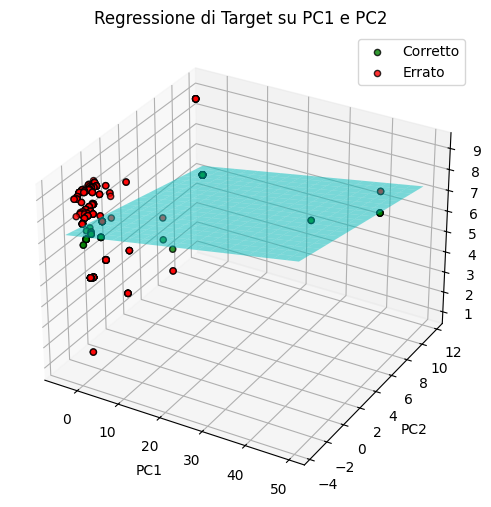

Numero di previsioni corrette: 70
Numero di previsioni errate: 279
Accuratezza del modello: 20.06%


Coefficiente di determinazione R^2: 0.93


/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


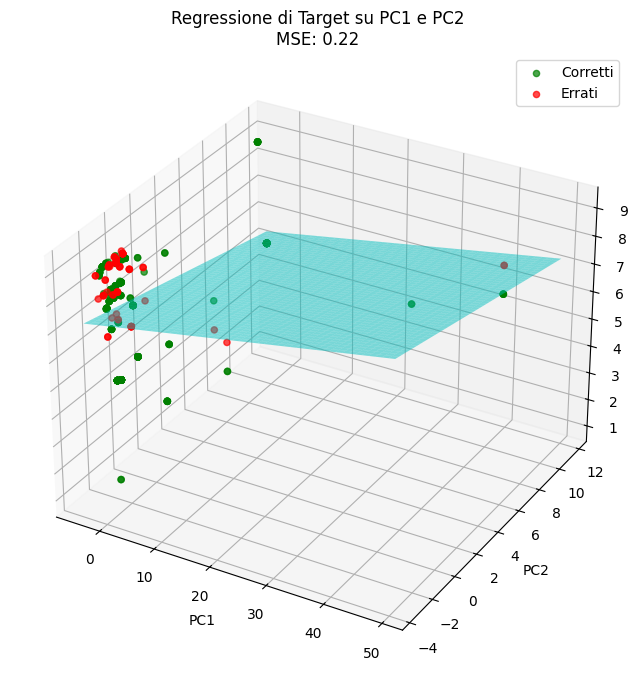

Numero di previsioni corrette: 284
Numero di previsioni errate: 65
Accuratezza del modello: 81.38%
